# XGBoost Model

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_recall_fscore_support
)
from scipy.stats import pearsonr
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
problem_types = ['classification','regression'] #regression or classification
input_types = ["correlation_variance_filter","random_forest_elimination","PCA","Factor_Analysis","genetic_algorithm"] #reduced features: , genetic_algorithm, PCA, Factor_Analysis, random_forest
seed = 254

In [3]:
def read_file(problem_type, input_file):
    """
    Read input features and recover target values (IC50 or Potency).

    Parameters:
        problem_type (str): 'regression' or 'classification'.
        input_file (str): Path to the input feature file.

    Returns:
        tuple:
            - X_indexed (pd.DataFrame): Feature DataFrame indexed by 'Molecule ChEMBL ID'.
            - target (pd.Series): Target values indexed by 'Molecule ChEMBL ID'.
    """
    if problem_type not in {'regression', 'classification'}:
        raise ValueError("Invalid problem_type. Must be 'regression' or 'classification'.")

    target_column = '-logIC50' if problem_type == 'regression' else 'Potency'

    # Load features and target data
    X = pd.read_csv(input_file)
    target = pd.read_csv('../../3_train_test_split/descriptors_all.csv', usecols=['Molecule ChEMBL ID', target_column])
    
    # Ensure correct merging without data loss
    merged = pd.merge(X, target, on='Molecule ChEMBL ID', how='inner')

    # Return the feature DataFrame and target Series
    return merged.drop(columns=target_column).set_index('Molecule ChEMBL ID'), merged[target_column]


In [4]:
def run_xgboost(problem_type, input_type, seed=42):
    """
    Train and evaluate XGBoost for regression or classification.
    """
    base_dir = f"../../4_feature_selection/{input_type}/"
    if input_type == "PCA":
        base_dir = os.path.join(base_dir, "PCA_results/PCA_components/")
    elif input_type == "Factor_Analysis":
        base_dir = os.path.join(base_dir, "FA_results/selected_features/")
    elif input_type == "genetic_algorithm":
        base_dir = os.path.join(base_dir, "xgboost/")

    problem = "reg" if problem_type == "regression" else "class"
    test_file = os.path.join(base_dir, f"test_{problem}.csv")

    # Load test dataset
    X_test, y_test = read_file(problem_type, test_file)
    test_chembl_ids = list(y_test.index)

    # Initialize label encoder for classification
    label_encoder = None
    if problem_type == "classification":
        label_encoder = LabelEncoder()
        y_test = label_encoder.fit_transform(y_test)

    # Set up RandomizedSearchCV parameters
    param_distributions = {
        'n_estimators': [100, 200, 500],
        'max_depth': [5, 10, 20],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }

    model = XGBRegressor(random_state=seed, objective="reg:squarederror") if problem_type == "regression" else \
        XGBClassifier(random_state=seed, eval_metric="logloss")

    scoring = 'neg_mean_squared_error' if problem_type == "regression" else 'accuracy'

    fold_metrics = []
    best_models = []

    for fold in range(1, 6):
        train_file = os.path.join(base_dir, f"train_{problem}_{fold}.csv")
        val_file = os.path.join(base_dir, f"val_{problem}_{fold}.csv")

        X_train, y_train = read_file(problem_type, train_file)
        X_val, y_val = read_file(problem_type, val_file)

        # Ensure matching feature columns
        missing_cols = set(X_train.columns) - set(X_test.columns)
        for col in missing_cols:
            X_test[col] = 0
        X_test = X_test[X_train.columns]

        if problem_type == "classification":
            y_train = label_encoder.fit_transform(y_train)
            y_val = label_encoder.transform(y_val)

        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=10,
            scoring=scoring,
            cv=3,
            n_jobs=-1,
            verbose=1,
            random_state=seed,
        )
        random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_
        best_models.append(best_model)

        y_val_pred = best_model.predict(X_val)
        metric = mean_squared_error(y_val, y_val_pred) if problem_type == "regression" else accuracy_score(y_val, y_val_pred)

        fold_metrics.append(metric)
        print(f"Fold {fold} - Best Model Metric: {metric:.4f}")

    avg_metric = np.mean(fold_metrics)
    print(f"Average Cross-Validation Metric: {avg_metric:.4f}")

    final_model = best_models[np.argmin(fold_metrics)] if problem_type == "regression" else \
        best_models[np.argmax(fold_metrics)]

    test_metric = mean_squared_error(y_test, final_model.predict(X_test)) if problem_type == "regression" else \
        accuracy_score(y_test, final_model.predict(X_test))
    print(f"Test Metric: {test_metric:.4f}")

    evaluate_model(final_model, X_test, y_test, problem_type, input_type, "XGBoost")

    return {
        'best_model': final_model,
        'test_predictions': final_model.predict(X_test),
        'test_metric': test_metric,
        'X_test': X_test,
        'y_test': y_test
    }


In [5]:
def evaluate_model(final_model, X_test, y_test, problem_type, input_type, model_type):
    """
    Evaluate the model, create plots, and save performance summary and predictions.
    """
    file_prefix = f"{model_type}_{problem_type}_{input_type}"
    y_pred = final_model.predict(X_test)

    if problem_type == "regression":
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        pearson_corr, _ = pearsonr(y_test, y_pred)

        performance_summary = pd.DataFrame([{
            "model_type": model_type,
            "problem_type": problem_type,
            "input_type": input_type,
            "mse": mse,
            "r2_score": r2,
            "pearson_corr": pearson_corr
        }])
        performance_summary.to_csv(f"{file_prefix}_performance_summary.csv", index=False)

        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": X_test.index,
            "True IC50": y_test,
            "Predicted IC50": y_pred
        })
        predictions.to_csv(f"{file_prefix}_predictions.csv", index=False)

        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
        plt.xlabel("True IC50")
        plt.ylabel("Predicted IC50")
        plt.title("Predicted vs True")
        plt.savefig(f"{file_prefix}_predicted_vs_true.png")
        plt.show()

    elif problem_type == "classification":
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

        performance_summary = pd.DataFrame([{
            "model_type": model_type,
            "problem_type": problem_type,
            "input_type": input_type,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }])
        performance_summary.to_csv(f"{file_prefix}_performance_summary.csv", index=False)

        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": X_test.index,
            "True Potency": y_test,
            "Predicted Potency": y_pred
        })
        predictions.to_csv(f"{file_prefix}_predictions.csv", index=False)

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
        disp.plot(cmap="Blues")
        plt.title("Confusion Matrix")
        plt.savefig(f"{file_prefix}_confusion_matrix.png")
        plt.show()


Training XGBoost for classification using correlation_variance_filter features...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 1 - Best Model Metric: 0.8381
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 2 - Best Model Metric: 0.7810
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 3 - Best Model Metric: 0.7810
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 4 - Best Model Metric: 0.7788
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 5 - Best Model Metric: 0.7212
Average Cross-Validation Metric: 0.7800
Test Metric: 0.7634


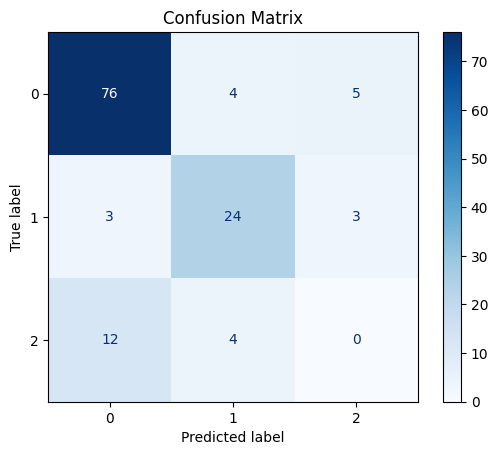

Training and evaluation complete
Training XGBoost for regression using correlation_variance_filter features...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
for input_type in input_types:
    for problem_type in problem_types:
        print(f"Training XGBoost for {problem_type} using {input_type} features...")
        results = run_xgboost(problem_type=problem_type, input_type=input_type, seed=seed)
        
        # Unpack results
        final_model = results["best_model"]
        X_test = results["X_test"]
        y_test = results["y_test"]
                
        print("Training and evaluation complete")
